In [1]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(palette='deep', style='whitegrid')

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

Install __[ipywidgets](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md#install)__, via
```bash
pip install ipywidgets ipympl
```
to ensure that interactive plots work.

# How changing the polynomial degree $M$ corresponds to the bias-variance tradeoff

### What to talk about
* Bias variance tradeoff caused by higher/lower polynomial degrees

In [2]:
%matplotlib widget
plt.figure(figsize=[10, 6])
def plot_fit(degree=1, seed=1):
    plt.cla()
    n_samples = 30

    np.random.seed(seed)
    true_fun = lambda X: np.sin(np.pi * X)
    X = np.sort(np.random.uniform(high=2, size=n_samples))
    y = true_fun(X) + np.random.randn(n_samples) * 0.1
    
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 2, 100)
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 2))
    plt.ylim((-2, 2))
    plt.legend(loc=1)
    plt.show()
interact(plot_fit, degree=(1, 30, 1), seed=(1, 10, 1));

interactive(children=(IntSlider(value=1, description='degree', max=30, min=1), IntSlider(value=1, description=…

# How changing the regularization strength $\lambda$ corresponds to the bias-variance tradeoff

### What to talk about
* Bias variance tradeoff caused by higher/lower regularization strength

In [3]:
%matplotlib widget
plt.figure(figsize=[10, 6])
def ridge_polynomial(log_lambda=0, seed=1):
    plt.cla()
    n_samples = 20

    true_fun = lambda X: np.sin(np.pi * X)
    np.random.seed(seed)
    X = np.sort(np.random.uniform(high=2, size=n_samples))
    y = true_fun(X) + np.random.randn(n_samples) * 0.1
    

    polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
    linear_regression = Ridge(alpha=np.power(10, log_lambda))
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 2, 100)
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 2))
    plt.ylim((-2, 2))
    plt.legend(loc=1)
    plt.show()
interact(ridge_polynomial, log_lambda=(-15, 10, 1.0), seed=(1, 10, 1));

interactive(children=(FloatSlider(value=0.0, description='log_lambda', max=10.0, min=-15.0, step=1.0), IntSlid…

# Shrinkage with $L_2$ (ridge) and $L_1$ (lasso) regularization

### What to talk about
* Other types of regularization are possible, not necessarily $L_2$, any $L_p$ norm for $p \geq 1$ can be used.
* Using $0 < p < 1$ leads to nonconvex objective.
* Using $L_0$ pseudonorm is impossible to optimize with tools discussed in this course, this is called *Compressed sensing* -> entire research discipline.
* $L_2$ is called **Ridge** leads to smaller values of $\mathbf{w}$ overall, but no entries are equal to 0. Also easier to optimize.
* $L_1$ is called **Lasso**, leads to sparse $\mathbf{w}$ (lots of entries are equal to 0)
* You can combine both penalties -> Elastic net
* http://www.ds100.org/sp17/assets/notebooks/linear_regression/norm_balls.png
* There exist other regularization schemes, doesn't have to be weight penalty. In general, regularization - decreasing model capacity / increasing bias / reducing variance.

In [4]:
data = fetch_california_housing()
X = data['data']
y = data['target']
names = data['feature_names']

In [5]:
# We filter warnings here as many fits are going to be bad due to too high or too low regularization
import warnings
warnings.filterwarnings('ignore')

lambdas = np.logspace(-4, 4, num=100)
# Ridge regression
coefs_ridge = []
for a in lambdas:
    ridge = ElasticNet(alpha=a, l1_ratio=0)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)
coefs_ridge = np.array(coefs_ridge)

# Lasso
coefs_lasso = []
for a in lambdas:
    lasso = ElasticNet(alpha=a, l1_ratio=1)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)
coefs_lasso = np.array(coefs_lasso)

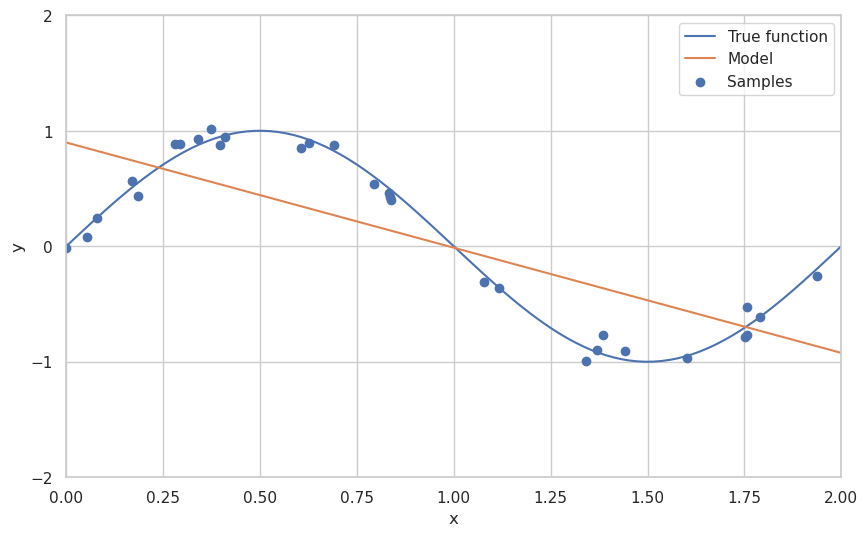

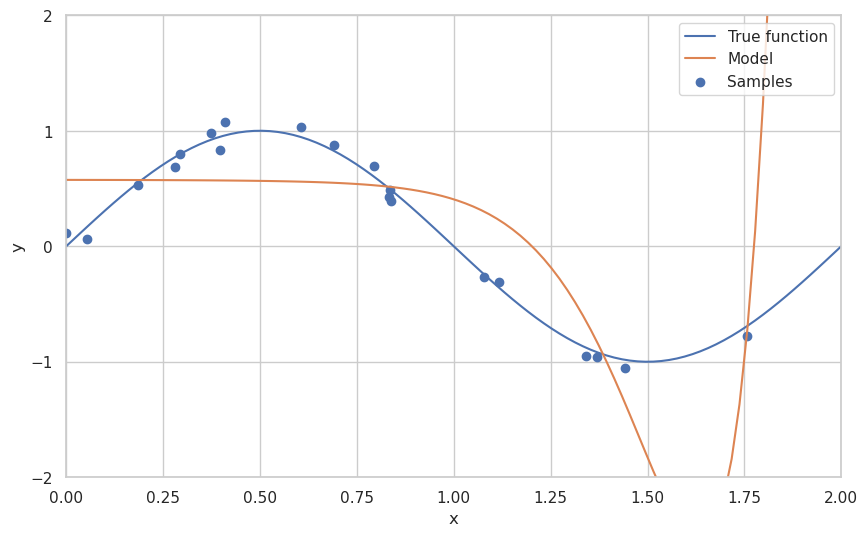

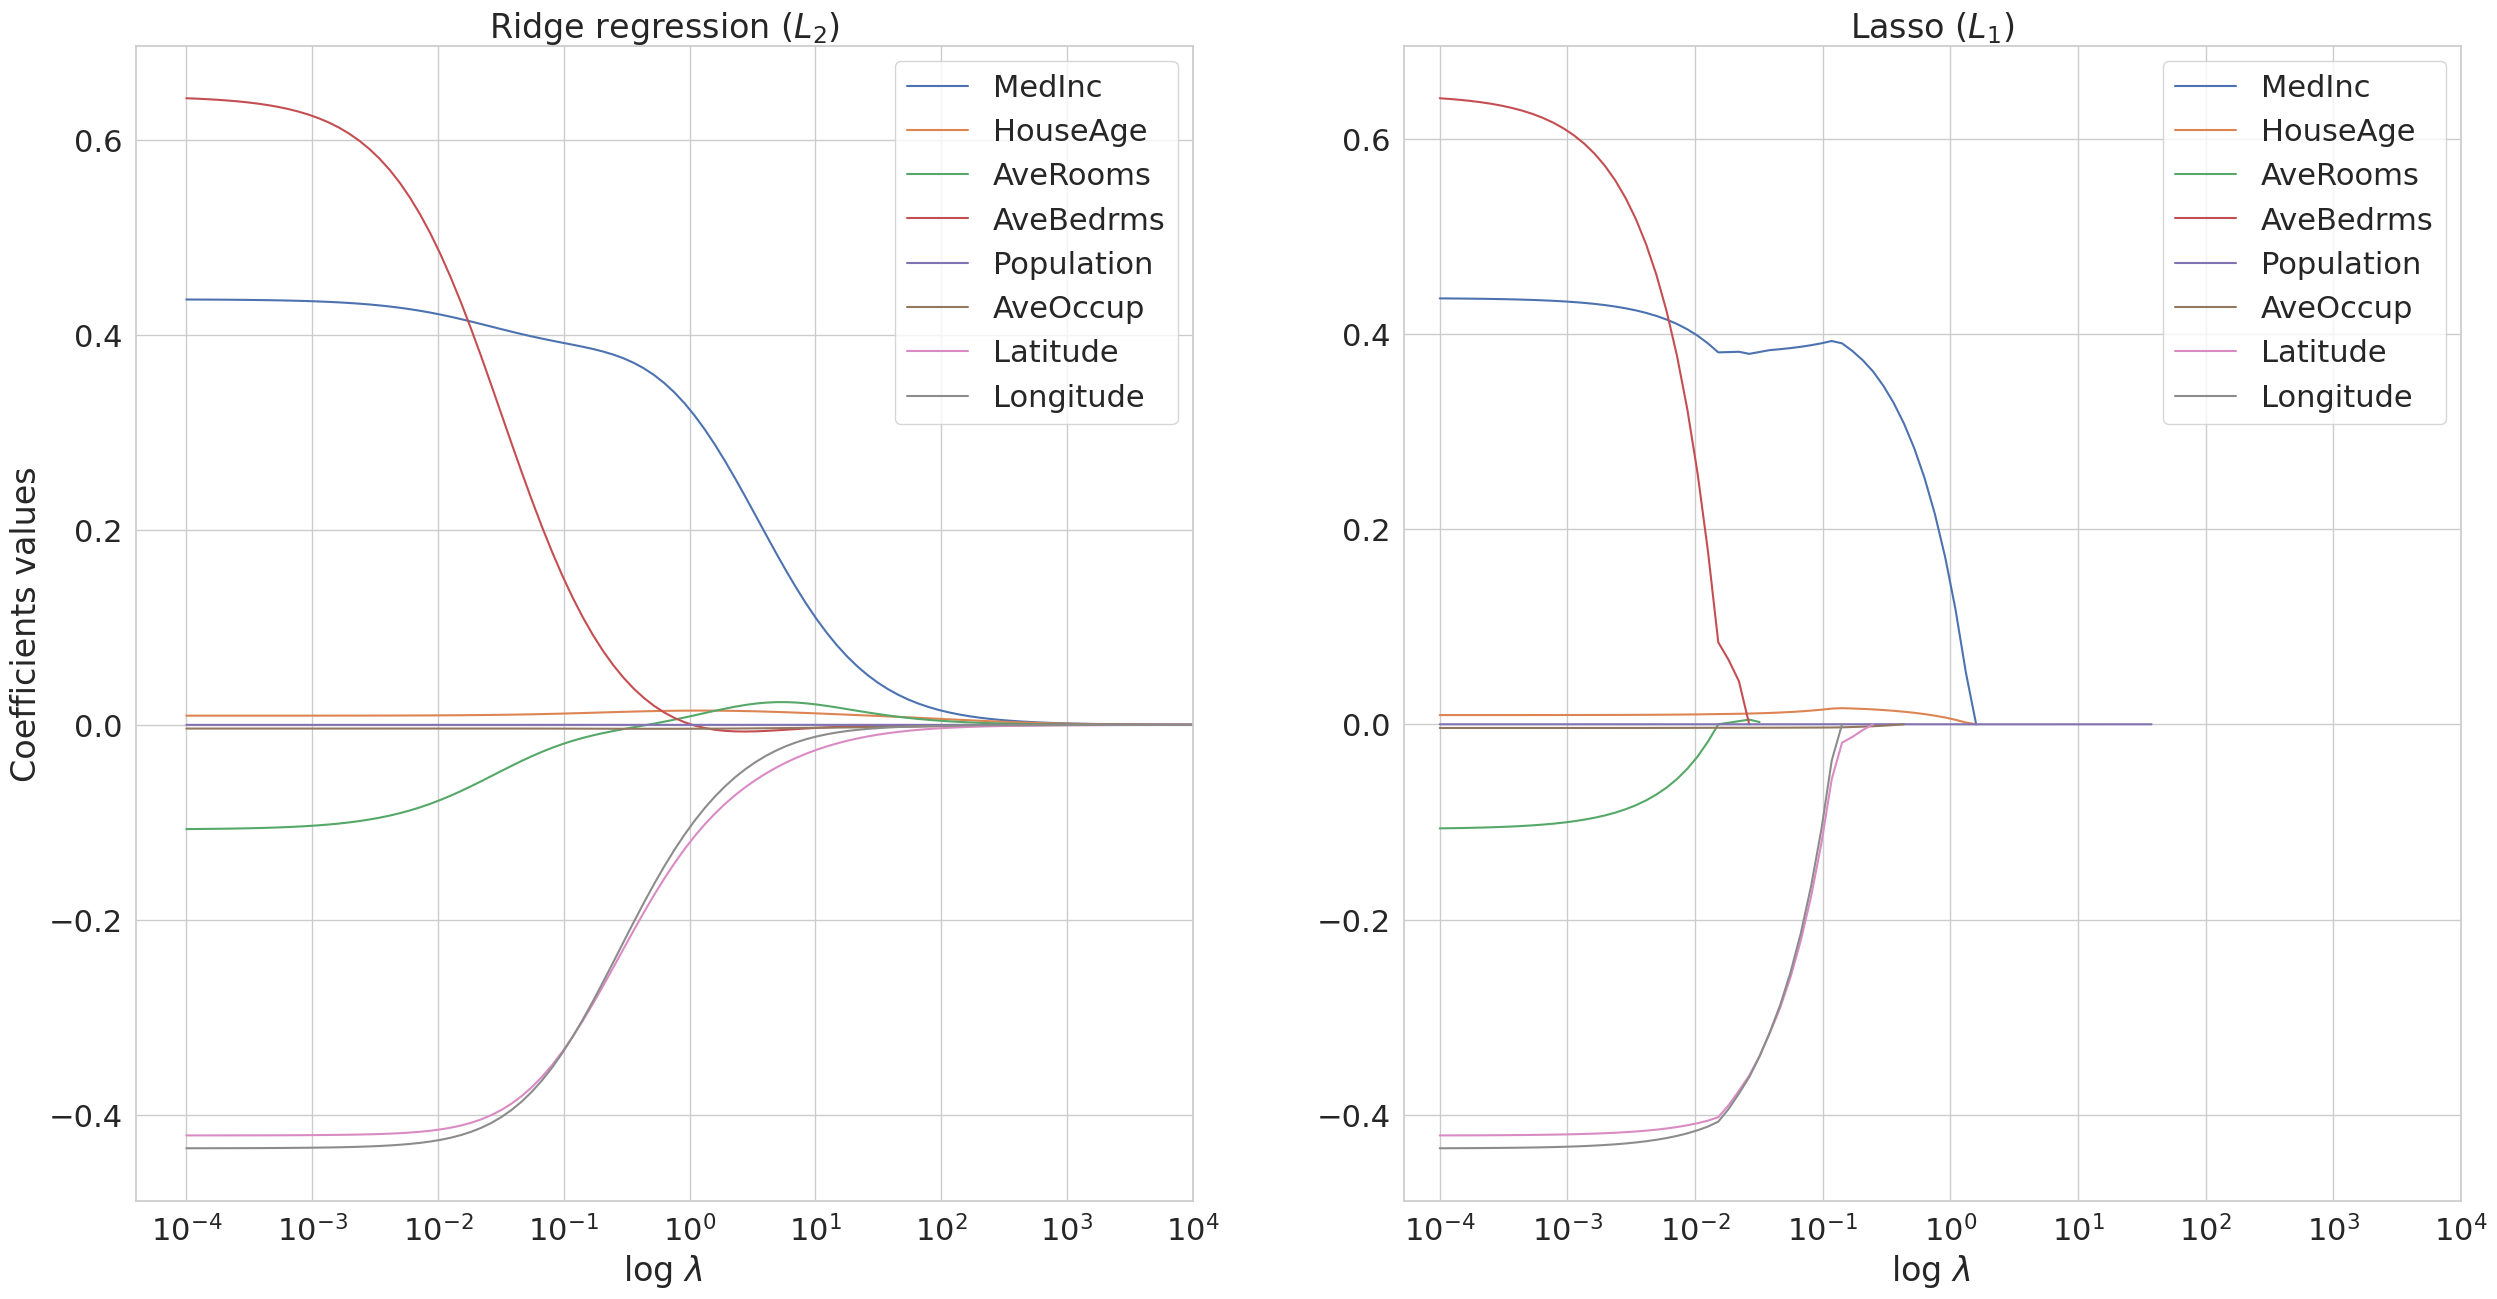

In [6]:
%matplotlib inline
sns.set(font_scale=2, style='whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[30, 15])
# Plot ridge
for i in range(coefs_ridge.shape[-1]):
    mask = coefs_ridge[:, i] != 0
    ax1.semilogx(lambdas[mask], coefs_ridge[:, i][mask], label=names[i])
ax1.set_xlabel('log $\lambda$ ')
ax1.set_ylabel('Coefficients values')
ax1.set_title('Ridge regression ($L_2$)')
ax1.set_xlim(right=1e4)
ax1.legend()

# Plot lasso
for i in range(coefs_ridge.shape[-1]):
    # don't plot the parts where the coefficient is equal to 0
    mask = coefs_lasso[:, i] != 0
    mask[np.where(~mask)[0][0]] = True  
    ax2.semilogx(lambdas[mask], coefs_lasso[:, i][mask], label=names[i])
ax2.set_xlabel('log $\lambda$ ')
ax2.set_title('Lasso ($L_1$)')
ax2.set_xlim(right=1e4)
ax2.legend()
plt.show()

### Interpretation of the plots
The plots show how values of model weights change as regularization scale increases.

In the plots we confirm these facts:
* $L_2$ leads to smaller values of $\mathbf{w}$ overall, but no entries are equal to 0.
* $L_1$ leads to sparse $\mathbf{w}$ (lots of entries are equal to 0 as log lambda increases).
* More on weights regularization in Section 3.4 of https://web.stanford.edu/~hastie/Papers/ESLII.pdf